# scGPT annotation of H9 and CFS with pre-trained scGPT_human model

In this notebook, you can find the cell type annotation of H9 and the [CFS dataset](https://doi.org/10.1101/2024.03.26.586760) using [scGPT](https://doi.org/10.1038/s41592-024-02201-0).  
Embedding was performed using [cell_embed.py](https://github.com/bowang-lab/scGPT/blob/main/scgpt/tasks/cell_emb.py), after which the cell embeddings were compared with a similary search to the cell embeddings of the pre-trained scGPT_human that contains annotated cell types.  
Through majority voting, the final cell type annotation is chosen for each cell. A tutorial can be found through [this link](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Reference_Mapping.ipynb).  
This work was performed using the compute resources from the Academic Leiden Interdisciplinary Cluster Environment (ALICE) provided by Leiden University.

In [1]:
# Imports
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set directory
os.chdir('/Users/cecileherbermann/Downloads/')

In [2]:
# Read data
h9 = sc.read_h5ad('H9_annotated.h5ad')
day0 = sc.read_h5ad('day0_annotated.h5ad')
day2 = sc.read_h5ad('day2_annotated.h5ad')
day14 = sc.read_h5ad('day14_annotated.h5ad')
day28 = sc.read_h5ad('day28_annotated.h5ad')

In [3]:
# List of datasets and celltype keys
datasets = [h9, day0, day2, day14, day28]
celltypes_keys = ['celltypes_scgpt', 'celltypes_scgpt_hvg']

# Apply reduce_celltypes to each combination of dataset and celltypes_key
for dataset in datasets:
    for celltypes_key in celltypes_keys:
        print(dataset.obs[celltypes_key].value_counts())
        
# Conclusion: there are many celltypes that are only present once, so we need a function to apply a threshold in order to improve visualizations later on 

celltypes_scgpt
hepatocyte                             5707
germ cell                              1449
mesothelial cell                        829
granulosa cell                          125
epithelial cell                         101
primordial germ cell                     91
epithelial cell of lung                  89
native cell                              59
ovarian surface epithelial cell          51
glial cell                               43
migratory enteric neural crest cell      31
mesenchymal cell                         22
neural cell                              17
cortical thymic epithelial cell          14
neural crest cell                         9
epithelial cell of nephron                5
keratinocyte                              4
oogonial cell                             3
neuron                                    3
skeletal muscle satellite cell            3
Sertoli cell                              3
neuroblast (sensu Vertebrata)             2
colon epithelial

In [4]:
# Function to reduce the amount of cell type labels
def reduce_celltypes(adata, celltypes_key, threshold=84):
    """
    Consolidate small cell type labels into 'other'.
    
    Parameters:
    adata (AnnData): The annotated data matrix.
    celltypes_key (str): The key for cell types in adata.obs.
    threshold (int, optional): The threshold below which cell types are consolidated. Default is 50.
    
    Returns:
    None: The function modifies the adata object in place.
    """
    counts = adata.obs[celltypes_key].value_counts()
    small_labels = counts[counts < threshold].index

    adata.obs[celltypes_key] = adata.obs[celltypes_key].astype(str)
    adata.obs[celltypes_key] = adata.obs[celltypes_key].apply(lambda x: 'other' if x in small_labels else x)

# Apply reduce_celltypes to each combination of dataset and celltypes_key
for dataset in datasets:
    for celltypes_key in celltypes_keys:
        reduce_celltypes(dataset, celltypes_key)

In [5]:
def get_custom_palette(n_colors):
    return [
        "#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", 
        "#A6D854", "#FFD92F", "#E5C494", "#B3B3B3", 
        "#1B9E77", "#D95F02", "#7570B3", "#E7298A",
        "#66A61E"
    ][:n_colors]


def plot_umap(dataset, celltypes_key, ax, title):
    # Count the number of cells for each cell type and sort them by counts in descending order
    celltype_counts = dataset.obs[celltypes_key].value_counts().sort_values(ascending=False)
    sorted_celltypes = celltype_counts.index
    
    # Define a custom colorblind-friendly palette with the required number of colors
    custom_palette = get_custom_palette(len(sorted_celltypes))
    
    # Ensure we have enough colors
    if len(sorted_celltypes) > len(custom_palette):
        raise ValueError("Not enough colors in the custom palette for the number of cell types.")
    
    # Create a color map from the custom palette with sorted cell type names
    celltype_colors = {celltype: custom_palette[i] for i, celltype in enumerate(sorted_celltypes)}
    
    # Append the counts to the cell type names
    dataset.obs[f'{celltypes_key}_with_counts'] = dataset.obs[celltypes_key].map(
        lambda x: f"{x} ({celltype_counts[x]})"
    )
    
    # Convert to categorical with specified order
    dataset.obs[f'{celltypes_key}_with_counts'] = pd.Categorical(
        dataset.obs[f'{celltypes_key}_with_counts'], 
        categories=[f"{celltype} ({celltype_counts[celltype]})" for celltype in sorted_celltypes],
        ordered=True
    )
    
    # Create a new color map with the updated cell type names
    celltype_colors_with_counts = {f"{celltype} ({celltype_counts[celltype]})": custom_palette[i] for i, celltype in enumerate(sorted_celltypes)}
    
    # Plot UMAP with custom colors
    sc.pl.umap(dataset, color=f'{celltypes_key}_with_counts', palette=celltype_colors_with_counts, ax=ax, show=False)
    ax.set_title(title)

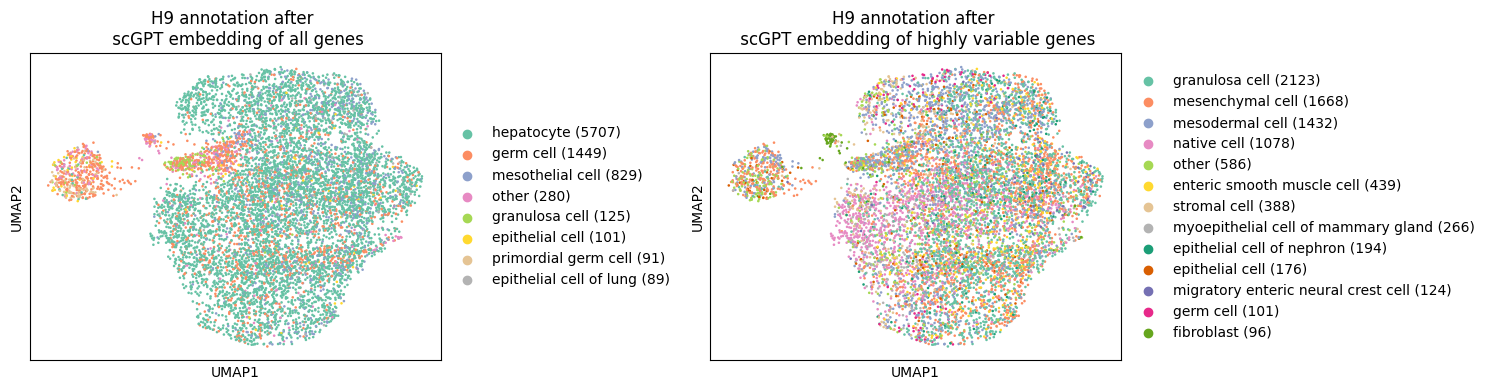

In [6]:
### H9 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(h9, 'celltypes_scgpt', axes[0], 'H9 annotation after \n scGPT embedding of all genes')
plot_umap(h9, 'celltypes_scgpt_hvg', axes[1], 'H9 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

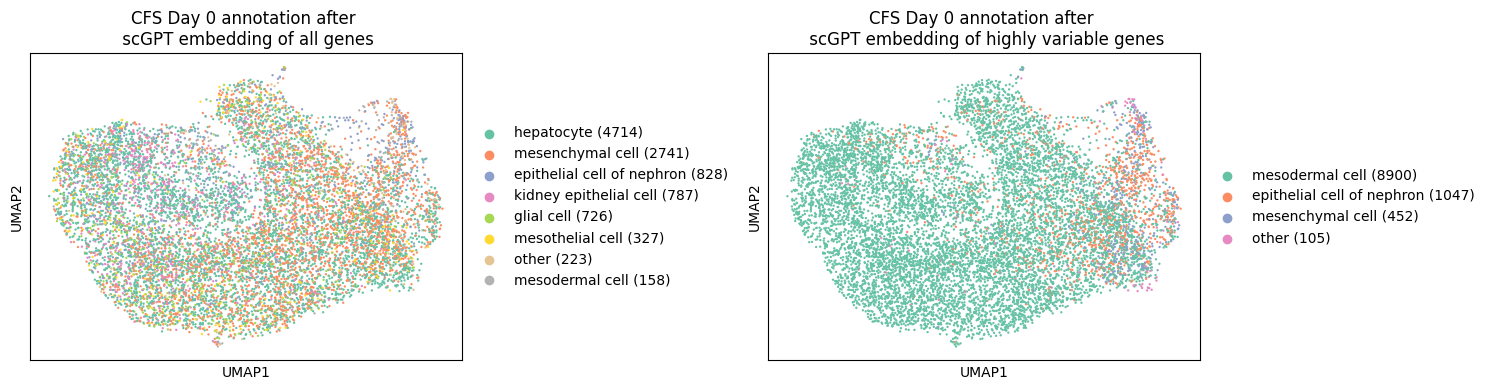

In [7]:
### Day0 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(day0, 'celltypes_scgpt', axes[0], 'CFS Day 0 annotation after \n scGPT embedding of all genes')
plot_umap(day0, 'celltypes_scgpt_hvg', axes[1], 'CFS Day 0 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

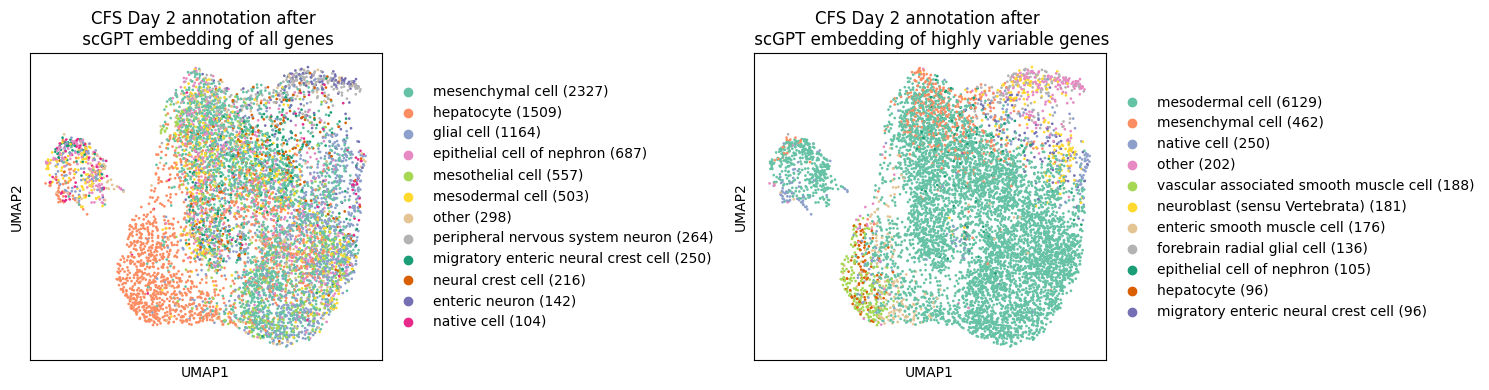

In [8]:
### Day2 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(day2, 'celltypes_scgpt', axes[0], 'CFS Day 2 annotation after \n scGPT embedding of all genes')
plot_umap(day2, 'celltypes_scgpt_hvg', axes[1], 'CFS Day 2 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [9]:
# Rename the cell types of the original publication to more descriptive names
rename_mapping = {
    'MN+dI6': 'motor neuron + dorsal interneuron 6',
    'MN+v0/1+dI3': 'motor neuron + ventral interneuron 0/1 + dorsal interneuron 3',
    'NC': 'non-classified',
    'NC_d': 'neural crest derivative',
    'v0+Dorsal' : 'ventral interneuron 0 + dorsal',
    'MN+v1+dI2/3': 'motor neuron + ventral interneuron 1 + dorsal interneuron 2/3',
    'MN+v1+dI3/6': 'motor neuron + ventral interneuron 1 + dorsal interneuron 3/6',
    'Sch': 'Schwann cell',
    'dI5+SN': 'dorsal interneuron 5 + sensory neuron',
    'SN': 'sensory neuron',
    'CS-like': 'CS-like',
    'NC_preEMT': 'neural crest pre-EMT',
    'v1+dI6': 'ventral interneuron 1 + dorsal interneuron 6'
}

# Apply the renaming to the 'clustering' column in day28.obs
day14.obs['celltypes_original'] = day14.obs['clustering'].replace(rename_mapping)

/var/folders/8j/tqhxq0y57p3fdz24yb_6j2gw0000gn/T/ipykernel_42395/3230795286.py:19: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  day14.obs['celltypes_original'] = day14.obs['clustering'].replace(rename_mapping)


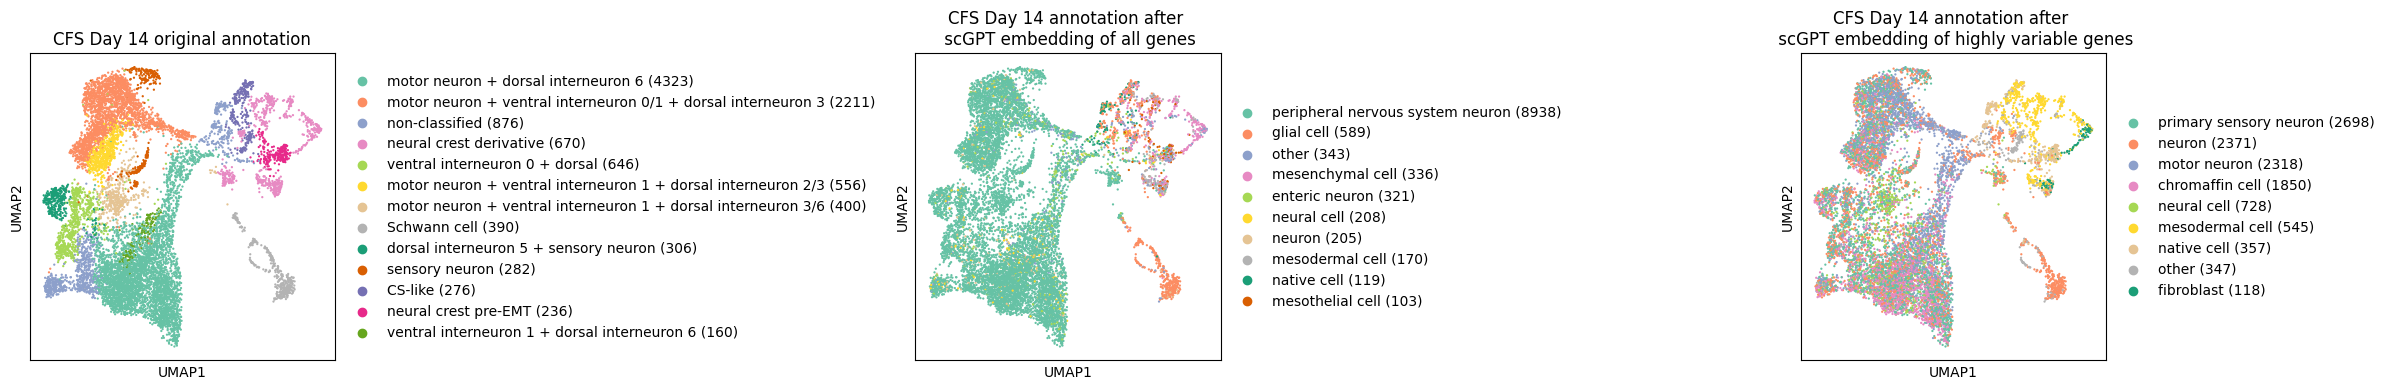

In [10]:
### Day14 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(24, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(day14, 'celltypes_original', axes[0], 'CFS Day 14 original annotation')
plot_umap(day14, 'celltypes_scgpt', axes[1], 'CFS Day 14 annotation after \n scGPT embedding of all genes')
plot_umap(day14, 'celltypes_scgpt_hvg', axes[2], 'CFS Day 14 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [11]:
# Rename the cell types of the original publication to more descriptive names
rename_mapping = {
    'MN+dI6': 'motor neuron + dorsal interneuron 6',
    'MN+Dorsal': 'motor neuron + dorsal',
    'MN+v0/1': 'motor neuron + ventral interneuron 0/1',
    'dI6': 'dorsal interneuron 6',
    'NC_d': 'neural crest derivative',
    'MN+v1': 'motor neuron + ventral interneuron 1',
    'v0/1+dI3': 'ventral interneuron 0/1 + dorsal interneuron 3',
    'CS-like': 'CS-like',  # Assuming CS-like is unchanged
    'NC_preEMT': 'neural crest pre-EMT',
    'dI5+SN': 'dorsal interneuron 5 + sensory neuron',
    'MN+v0/1+dI2/6': 'motor neuron + ventral interneuron 0/1 + dorsal interneuron 2/6',
    'SN': 'sensory neuron',
    'Sch': 'Schwann cell'
}

# Apply the renaming to the 'clustering' column in day28.obs
day28.obs['celltypes_original'] = day28.obs['clustering'].replace(rename_mapping)


/var/folders/8j/tqhxq0y57p3fdz24yb_6j2gw0000gn/T/ipykernel_42395/830613926.py:19: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  day28.obs['celltypes_original'] = day28.obs['clustering'].replace(rename_mapping)


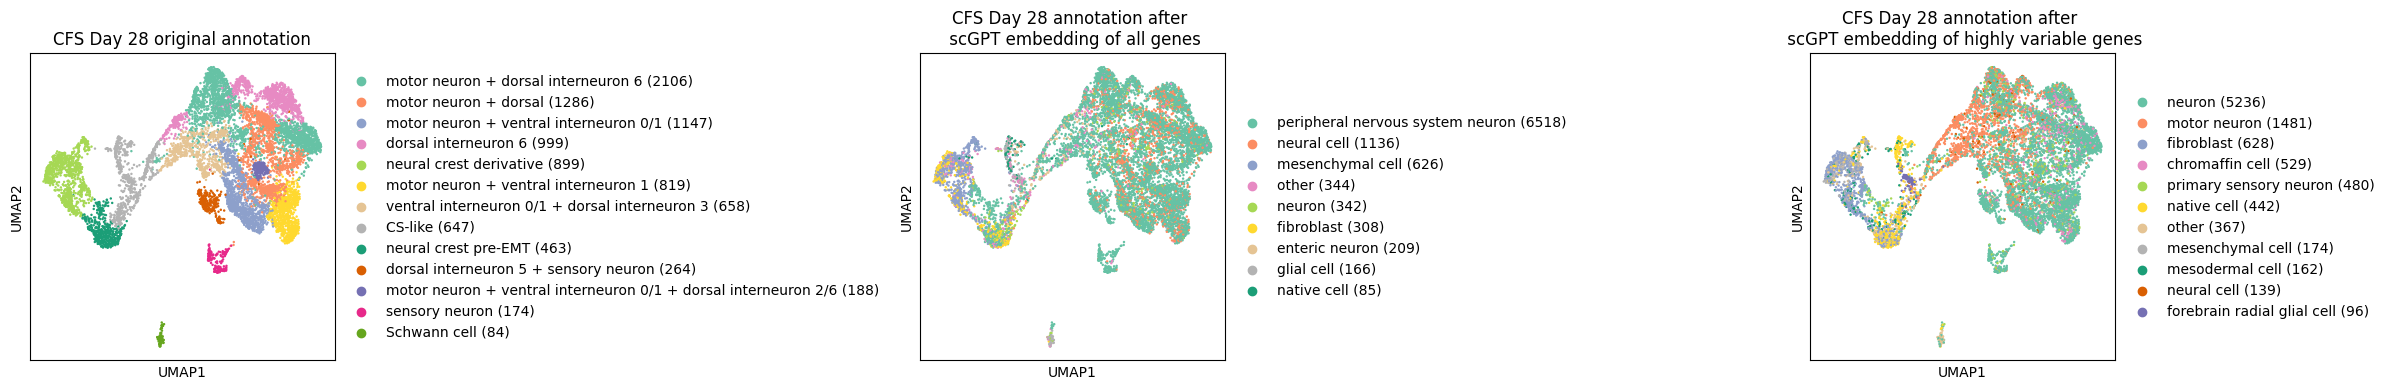

In [12]:
### Day28 ###
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(24, 4))

# Plot the UMAPs side by side with custom titles
plot_umap(day28, 'celltypes_original', axes[0], 'CFS Day 28 original annotation')
plot_umap(day28, 'celltypes_scgpt', axes[1], 'CFS Day 28 annotation after \n scGPT embedding of all genes')
plot_umap(day28, 'celltypes_scgpt_hvg', axes[2], 'CFS Day 28 annotation after \n scGPT embedding of highly variable genes')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()